# Datagen Walkthrough

Usage for datagen is set as:  
<tt>datagen.py input_yaml output_yaml</tt>

The only way to pass in parameters to datagen is through the yaml


## DatagenBase Class

The DatagenBase class provides a common framework for all datagen scripts to use. 

DatagenBase features include:
<ul>
<li> Commandline arguments parsing
<li> Provides parse_yaml() to read in input_yaml
<ul><li> YML Class loading support </ul>
<li> write_output() function to generate datagen outputs
    <ul>
    <li> Writes out self.suite to params.yml
    <li> Optionally generates a datagen_types.h with c struct/enums/defines.
    </ul>
<li> Setting the random library seed from the test seed 
<li> Sets up useful debugging simlinks in the test run directory 
</ul>

##  Basic Datagen script

TODO - Give an example of how to implement and use the DatagenBase class

##  Datagen param objects 

Since yml parameters can get complicated and busy, using python classes to represent them is recommended.

### Dataclasses

Dataclasses are more recent python feature (>3.6+) which lets you define a class variables using name, type and optionally the default value.  It autogenerates the class's init and repr functions and lets us keep the class definitions to just the important information. It is a perfect fit for loading yaml into python.

Highly recommend anyone unfamiliar with dataclasses to see the official documentation: https://docs.python.org/3/library/dataclasses.html

### YAMLParamsBase 

YAMLParamsBase is a base class which adds support for loading and dumping yaml through classes. 

Features include:
<ul>
<li> Enforces correct yaml names
<li> Applies constructor's default values
<li> Converts Enums from string to their specified typehint (Based on the dataclass typehint)
<li> Add type checking (Based on the dataclass typehint)
</ul>

### dataclasses.field wrapper

For convinience, there a field wrapper from yaml_params_base.py to help with dataclass fields. These are intended to make intent clearer in the context of datagen and help catch common issues. There are three directions you can specify to this wrapper.

<ul>
<li><b>'out'</b> - OUT Only. used for datagen generated parameters which have no direct control from test yml. In other words, the param will always have the default value.
<li><b>'in'</b> - IN Only. used for parameters which are only used by datagen (datagen control parameters). The param will be tagged so write_output will not dump it to the output yml
<li><b>'in_out'</b> - IN and OUT. default option. Used for parameters which can be set from yml and should be incluced in the final params.yml. 
</ul>

Each of these take the default/initial value as an argument. 

A datagen param class for this example would look like the following:

In [1]:
from dataclasses import dataclass
import sys
sys.path.append( '..' )
import datagenDV as dg
from enum import IntEnum

class FRAME_SIZE_E(IntEnum):
    SMALL = 1
    TYPICAL = 2
    WIDE = 3
    TALL = 4
    LARGE = 5
    NUM_FRAMES_SIZES = 6

@dataclass
class DatagenParams(dg.YAMLParamsBase):
    #YAML input fields
    #yml_field(<default value>) see explanation above
    FRAME_COUNT  : int   = dg.field(5)
    FRAME_WIDTH  : int   = dg.field(640)
    FRAME_HEIGHT : int   = dg.field(480)
    ITERATIONS   : int   = dg.field(1)

    #These parameters are used to generate FRAMES, so in_only_field is used
    #Use lambda to avoid a mutable default values
    MEM_PADDING  : list  = dg.field(lambda:["RAND"], dir='in')
    MEM_REGIONS  : list  = dg.field(lambda:["RAND"], dir='in')

    FRAME_SIZE   : FRAME_SIZE_E  = dg.field("SMALL")
    CONNECTION_TABLE : str = dg.field(None)

    #FRAMES is generated by datagen so use out_only_field
    FRAMES : list = dg.field(lambda:[], dir='out')

<b>Important Note</b>:
 
Default values should always be either immutable types or a function/class to generate the value (called a "default factory" by datatypes). *_param functions will notify the user if they attempt to pass in a mutable type.

See this explanation of why mutable default values are problematic: https://docs.python-guide.org/writing/gotchas/#mutable-default-arguments



### Quick Review of "lambda":

"lambda" is how you can define an annoymous function in python by wrapping the creation of the mutable default values(i.e lists) in a lambda function, a new list is generated each time an object is created. The yml_field wrappers will warn users if they attempt to use mutable types. 

More information on lambda can be found at: https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions

In [2]:
#Standard function definition
def create_list1():
    return ["func", "created", "list"]

#Equivilent lambda function definition
create_list2 = lambda:["lambda", "created", "list"]

print(f"func def: type = {type(create_list1)} return value: {create_list1()}")
print(f"lambda: type = {type(create_list2)} return value: {create_list2()}")

func def: type = <class 'function'> return value: ['func', 'created', 'list']
lambda: type = <class 'function'> return value: ['lambda', 'created', 'list']


### Changes to the YAML

You can use either '!' or a field named "DatagenClass". "DatagenClass" allows the YAML to be preprocessed by other scripts without knowing the full class definition.

DatagenBase will automatically convert the "DatagenClass" field into a '!' tag before loading the yaml.

The user only needs to specify the DatagenClass field and register the class in their Datagen class \_\_init\_\_() function

In [3]:
_="""
datagen_test:
  dg_params:
    DatagenClass: DatagenParams # <-----------
    CONNECTION_TABLE: conn-tbl-01.xml
    ITERATIONS: 1
    #<other params>
"""

In [4]:
class TemplateDatagen(dg.DatagenBase):
    def __init__(self):
        #Call base constructor - parses args, creates debug symlinks, sets up logging
        super().__init__(description="Template datagen example script")
        #Register python<->yaml classes. 
        #Must be after super().init and before self.parse_yaml()
        self.yaml.register_class(DatagenParams)
        self.parse_yaml()

    def main(self):
        dg_params = self.yaml_dict['datagen_test']['dg_params']
        # ...
        self.write_outputs()

##  Auto-generating C headers for Datagen classes 

To avoid maintaining both a C and python version of params, DatagenBase provides an optional way to auto-generate C headers for parameters.

It does this by leveraging the python ctypes library and ctypes_helper.py along with the dataclass type hints. 

The current flow supports constants, enums and classes.

### Constants

Python constants you want to reuse in C should be tracked in a dictionary using name and value (c_defines in this example) 

In [5]:
MAX_FRAMES = 11
NUM_MEM_PADDING = 4
NUM_MEM_REGIONS = 6

c_defines = {'MAX_FRAMES' : MAX_FRAMES,
            'NUM_MEM_PADDING': NUM_MEM_PADDING,
            'NUM_MEM_REGIONS': NUM_MEM_REGIONS }

### Enums 

Enums to be exported to C should be tracked in a list (c_enums in this example)

In [6]:
class MEM_REGIONS_E(IntEnum):
    ROM = 1
    RAM = 2
    CD = 3
    FLOPPY = 4
    MAGNET_TAPE = 5
    RAND = 6

class FRAME_SIZE_E(IntEnum):
    SMALL = 1
    TYPICAL = 2
    WIDE = 3
    TALL = 4
    LARGE = 5
    NUM_FRAMES_SIZES = 6

c_enums = [MEM_REGIONS_E,FRAME_SIZE_E]

### Classes

Since C requires a bit more information about types and lists, we need to modify our DatagenParams class.

Our class should now inherit from both YAMLParamsBase and ctype.Structure. Inheiriting from ctype.Structure is used under the hood to generate the header properly for nested types. 

 If there are lists, then the user needs to provide the type and maximum size for the list using a dictionary lookup (See clist_info_lookup below).  

If a user wants specific bit widths or unsigned integers, then they should specify the field using the appropriate ctype class. (For example, ctypes.c_uint32 for unsigned 32 bit integer). If python types are specified, then generate_hfields() will convert to the default ctype equivilient.

After creating the class, the user needs to call generate_hfields() on the class.

See ctypes_helper.py for the conversion between ctypes types and std C types.

Finally the user should track these classes as a list. (c_structs in this example)

In [7]:
import ctypes
@dataclass
class Frame(dg.YAMLParamsBase, ctypes.Structure):
    width : ctypes.c_uint32
    height : ctypes.c_uint32
    name : ctypes.c_wchar_p
    chksum : ctypes.c_uint32
    padding : ctypes.c_uint32
    location : MEM_REGIONS_E

@dataclass
class DatagenParams(dg.YAMLParamsBase, ctypes.Structure):
    clist_info_lookup = {}

    #YAML input fields
    FRAME_COUNT  : ctypes.c_uint32   = dg.field(5)
    FRAME_WIDTH  : ctypes.c_uint32   = dg.field(640)
    FRAME_HEIGHT : ctypes.c_uint32   = dg.field(480)
    ITERATIONS   : ctypes.c_uint32   = dg.field(1)

    MEM_PADDING  : list  = dg.field(lambda:["RAND"], dir='in')
    MEM_REGIONS  : list  = dg.field(lambda:["RAND"], dir='in')

    FRAME_SIZE   : FRAME_SIZE_E  = dg.field("SMALL") #Default to small frames if not specified
    CONNECTION_TABLE : str = dg.field(None)

    FRAMES : list = dg.field(lambda:[], dir='out')
    #Provide C header type information (type, max length)
    clist_info_lookup["FRAMES"] = (Frame, MAX_FRAMES) 

DatagenParams.generate_hfields(DatagenParams.clist_info_lookup)

#Order matters for C compile
c_structs = [Frame, DatagenParams]

### Datagen.write_outputs()

Finally the user needs to pass c_defines, c_enums, c_structs to Datagen.write_outputs().

In [8]:
class TemplateDatagen(dg.DatagenBase):
    #...
    def main(self):
        # ...
        
        #Writes output YAML and generates datagen_types.h
        self.write_outputs(structs =  c_structs,
                            enums =  c_enums,
                            defines = c_defines )

The resulting datagen_types.h is included in the elf automatically and looks like the following. 

The autogenerated file is symlinked to the test run directory at:
<tt>$RUNWS/include_files/datagen_types.h</tt>

In [9]:
_="""
//
// Auto-generated file - do not hand-edit
//
#ifndef __DATAGEN_TYPES_H__
#define __DATAGEN_TYPES_H__

#define MAX_FRAMES ( 11 ) 
#define NUM_MEM_PADDING ( 4 ) 
#define NUM_MEM_REGIONS ( 6 ) 


typedef enum {
  ROM = 1,
  RAM = 2,
  CD = 3,
  FLOPPY = 4,
  MAGNET_TAPE = 5,
  RAND = 6
} MEM_REGIONS_E;

typedef enum {
  SMALL = 1,
  TYPICAL = 2,
  WIDE = 3,
  TALL = 4,
  LARGE = 5,
  NUM_FRAMES_SIZES = 6
} FRAME_SIZE_E;

typedef struct Frame {
   UINT32          width;
   UINT32          height;
   const char*     name;
   UINT32          chksum;
   UINT32          padding;
   MEM_REGIONS_E   location;
} Frame, *PFrame;

typedef struct DatagenParams {
   UINT32          FRAME_COUNT;
   UINT32          FRAME_WIDTH;
   UINT32          FRAME_HEIGHT;
   UINT32          ITERATIONS;
   FRAME_SIZE_E    FRAME_SIZE;
   const char*     CONNECTION_TABLE;
   Frame           FRAMES[11];
} DatagenParams, *PDatagenParams;

#endif // __DATAGEN_TYPES_H__
"""

##  pyvsc Constrained Randomization 

Constained randomization is very familiar to anyone who has worked with UVM and SystemVerilog. The pyvsc library is a way to write System Verilog style constraints in python. 

For the features see:
https://pyvsc.readthedocs.io/en/latest/

### Updating a params object to include randomization 
Lets start with a simple datagen params object with a few simple fields which we want to randomly constrain: width and height. We will also have an overall frame size.

In [10]:
@dataclass
class FrameParams(dg.YAMLParamsBase):
    #None is used as the default value since we want to randomize by default
    FRAME_SIZE : int = dg.field(None, dir='in')
    FRAME_WIDTH  : int = dg.field(None)
    FRAME_HEIGHT : int = dg.field(None)

We would like to have a constraint for the following

FRAME_SIZE = FRAME_DEPTH * FRAME_WIDTH * FRAME_HEIGHT

We would also like for any (or all) four of these parameters to be able to be overrode from the yml input

We could write a complex if/else sequential randomization. This quickly becomes a large mess unless you drastically cut back in scope of what you want to be controllable. Plus you likely will end up with very poor random distribution unless you are very careful. 

Instead we can use pyvsc. To do so, we need to make the following changes to our class:
<ol>
<li> Add the "@vsc.randobj" class decorator
<li> Create random fields for each field you want to constrain.
<li> Add the "@rand_YML_override" class decorator
</ol>

The "@randobj" class decorator is needed by the pyvsc library. It looks for pyvsc random types and constraints and provides the randomize() function. 

Random field names need to match the yml parameters, but with a "rand_" prefix.

The "@rand_YML_override" class decorator ties rand_ prefixed fields with the yaml param fields which match. It creates a constraint if the value "is not None", otherwise it copies back the randomized value after randomization.

@rand_dataclass evokes all three decoarators in the proper order.

Random fields are configured using rand_field() which accepts a vsc random type and the parameters for that type. They do not need a typehint, so elipsis (...) is used as a "don't care".

In [11]:
import vsc
# from datagenDV.rand_params_base import rand_field, rand_YML_override

#This order for the decorators is required!
# @vsc.randobj
# @dg.rand_YML_override
# @dataclass

#This single decorator replaces the three above
@dg.rand_dataclass
class FrameParams(dg.YAMLParamsBase):
    # rand_field requires the vsc random class plus the needed parameters for that type
    # In this case, we use the rand_bit_t with a size of 32 bits, but allocating extra space for size
    FRAME_SIZE   : int = dg.rand_field(vsc.rand_bit_t, 64)
    FRAME_WIDTH  : int = dg.rand_field(vsc.rand_bit_t, 32)
    FRAME_HEIGHT : int = dg.rand_field(vsc.rand_bit_t, 32)


If we create and randomize this object as written, then we can see the behavior without constraints

In [12]:
frame = FrameParams()
frame.randomize()
print(frame)

FrameParams(FRAME_SIZE=689432656712092297, FRAME_WIDTH=3906065455, FRAME_HEIGHT=3963503871)


We can see that we got some unconstrained random uint32 values as expected.

Now lets modify our class with some constraints. We will add constraints for max/min size and to calculate the size from each dimension.

Constraints are specified with "@constraint" function decorators.

In [13]:
@dg.rand_dataclass
class FrameParams(dg.YAMLParamsBase):
    FRAME_SIZE   : int = dg.rand_field(vsc.rand_bit_t, 64)
    FRAME_WIDTH  : int = dg.rand_field(vsc.rand_bit_t, 32)
    FRAME_HEIGHT : int = dg.rand_field(vsc.rand_bit_t, 32)

    @vsc.constraint
    def sizes_c(self):
        self.rand_FRAME_SIZE.inside(vsc.rangelist((16, 65536)))
        # self.rand_FRAME_SIZE.not_inside(vsc.rangelist((10000, 20000)))
        self.rand_FRAME_WIDTH.inside(vsc.rangelist((4, 256)))
        self.rand_FRAME_HEIGHT.inside(vsc.rangelist((4, 256)))

    @vsc.constraint
    def frame_dimensions_c(self):
        self.rand_FRAME_SIZE == self.rand_FRAME_WIDTH * self.rand_FRAME_HEIGHT
    

Lets run again and see the results.

In [14]:
frame = FrameParams()
frame.randomize()
print(frame)

assert frame.FRAME_SIZE == (frame.FRAME_WIDTH * frame.FRAME_HEIGHT), \
    "Make sure we didn't overflow to get our answer :)"

FrameParams(FRAME_SIZE=3042, FRAME_WIDTH=18, FRAME_HEIGHT=169)


The results show that our constraints modified the randomization correctly.

### Checking Random Distribution

Lets plot the distributions if we randomize 1000 times. 

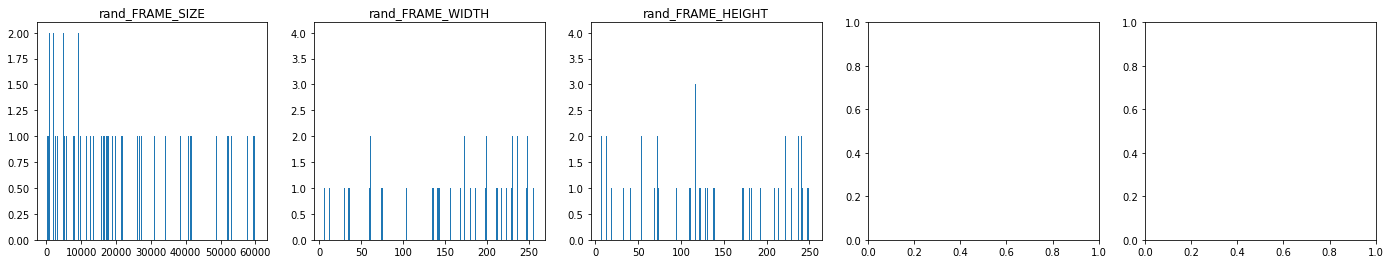

In [15]:
import matplotlib.pyplot as plt
def randomize_and_graph_histograms(rand_class, N=1000):
  class_inst = rand_class()
  var_list = {}
  #Randomize N times, collecting values for graphing
  for i in range(0,N):
    class_inst.randomize()
    class_inst_vars =  vars(class_inst)
    for v in class_inst_vars:
      if v.startswith("rand"):
        var_list.setdefault(v, []).append(class_inst_vars[v].get_val())
  
  for i,k in enumerate(var_list.keys()):
    if i % 5 == 0:
      fig, axs = plt.subplots(1,5) 
    axs[i%5].hist(var_list[k], bins=500)
    axs[i%5].set_title(k)
    if i % 5 == 4:
      fig.set_size_inches(24, 4)
      fig.show()

  if i % 5 != 4:
    fig.set_size_inches(24, 4)
    fig.show()
      
#Call our generic function with FrameParams and randomize it 10000 times  
randomize_and_graph_histograms(FrameParams, N=100)

We can see that random distribution isn't perfect and sometimes tends to stick to outside bounds. This isn't too surprising given the constraints we gave (multiplication constraint).

Test writers should investigate what kind of distribution they get from their constraints and determine if it is sufficient.

### Params Constraining Randomization
Now lets show how we can control the randomization through non-rand params. This would typically be through test yaml params.

In [16]:
print("First we'll try to constrain FRAME_SIZE")
frame = FrameParams(FRAME_SIZE=2048)
frame.randomize()
print(frame)

First we'll try to constrain FRAME_SIZE
FrameParams(FRAME_SIZE=2048, FRAME_WIDTH=32, FRAME_HEIGHT=64)


In [17]:
print("Now constrain WIDTH")
frame = FrameParams(FRAME_WIDTH=128)
frame.randomize()
print(frame)

Now constrain WIDTH
FrameParams(FRAME_SIZE=28800, FRAME_WIDTH=128, FRAME_HEIGHT=225)


If we try to override our values with out of bound values, then our constraints will fail and inform the user.

It is recommended to call randomize with solve_fail_debug=1 to print information on the failing constraint.

In [18]:
print("We can also catch out of bound overrides")
frame = FrameParams(FRAME_SIZE=1000000)
try:
    frame.randomize(solve_fail_debug=1)
except vsc.SolveFailure:
    print("We failed to solve!")


We can also catch out of bound overrides
Problem Set: 2 constraints
  <unknown>:
    rand_FRAME_SIZE in [16..65536];
  <unknown>:
    (rand_FRAME_SIZE == 1000000);

We failed to solve!


For more examples on how to use pyvsc to write more complex constraints, see the documentation: https://pyvsc.readthedocs.io/

You can also search the github for examples: https://github.com/fvutils/pyvsc